# EPL Prediction Using Machine Learning

![EPL](https://cdn.comparitech.com/wp-content/uploads/2017/08/2017-08-24-13_56_41-newpremierleaguelogo_800x450.jpg-1296%C3%97729-e1503597444647.jpg)

##In this Program I have tried to Predict the Top 6 players who will score more than 8 points next gameweek.

You can have a look at this repository - https://github.com/277roshan/MachineLearningFinalProject, from which I have tried modifying it. You can even have a look at my repository - https://github.com/SiddharthSSR

In [0]:
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
import json
import matplotlib.pyplot as plt

##Taking the Teams from the Table

We are following these steps:
1. First,  We will get the data from the following website - http://www.espnfc.com/barclays-premier-league/23/table
2. We will only take the data we want, and arrange the teams according to the position
3. We are also converting the data into a csv file so it is easy to store



In [18]:
# Downloading and parsing the data into a Python dict

team_dict = {}

url = 'http://www.espnfc.com/barclays-premier-league/23/table'
r  = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser') 
# Note: html5lib deals better with broken html than lxml

for td in soup.findAll('td', { 'class' : 'pos' }):
    rank = int(td.text)
    res = [i.text for i in td.next_siblings if isinstance(i, bs4.element.Tag) and i.text!='\xa0']
    team_name = res[0].strip()
    print team_name, rank
    
    values = []
    for i in res[1:]:
        a = i.replace(u'\xa0', '0')
        values.append(int(a))
    
    team_dict[team_name] = [rank] + values


for i in team_dict:
    remove_val = [1, 8, 14, 20]
    team = team_dict[i]
    shift = 0 
    for j in remove_val:
       
        team.pop(j + shift)
        shift = shift - 1
    
    


df = pd.DataFrame.from_dict(team_dict, orient='index')
cols = ['Pos','P_ov','W_ov','D_ov','L_ov','F_ov','A_ov',
            'W_hm','D_hm','L_hm','F_hm','A_hm', 'W_aw',
            'D_aw','L_aw','F_aw','A_aw','GD','PTS']
df.columns = cols
df = df.sort_values('Pos')
df['team'] = df.index
df = df[['team']+cols]
df


df.to_csv('./fantasyfootballscout.csv', index=False)

Manchester City 1
Manchester United 2
Chelsea 3
Liverpool 4
Tottenham Hotspur 5
Arsenal 6
Leicester City 7
Burnley 8
Everton 9
Watford 10
West Ham United 11
AFC Bournemouth 12
Crystal Palace 13
Huddersfield Town 14
Newcastle United 15
Brighton & Hove Albion 16
Stoke City 17
Southampton 18
West Bromwich Albion 19
Swansea City 20


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  # This is added back by InteractiveShellApp.init_path()


## Taking Information about the Players

Now we follow these steps:

1. We are taking the data from the following json file - https://fantasy.premierleague.com/drf/bootstrap-static
2. Then we are taking the information of the players


In [19]:
#import numpy as np
#import matplotlib.pyplot as plt
#plt.ioff()

url = "https://fantasy.premierleague.com/drf/bootstrap-static"
r  = requests.get(url)
data = json.loads(r.text)
all_players = data['elements']

player_dict = {}
for i in all_players:
    player_dict[i['id']] = i['web_name']

print player_dict

{1: u'Ospina', 2: u'Cech', 3: u'Martinez', 4: u'Koscielny', 5: u'Mertesacker', 6: u'Gabriel', 7: u'Beller\xedn', 8: u'Gibbs', 9: u'Jenkinson', 10: u'Monreal', 11: u'Holding', 12: u'Mustafi', 13: u'Kolasinac', 14: u'S\xe1nchez', 15: u'Walcott', 16: u'\xd6zil', 17: u'Cazorla', 18: u'Ramsey', 19: u'Chamberlain', 20: u'Coquelin', 21: u'Iwobi', 22: u'Elneny', 23: u'Xhaka', 24: u'Wilshere', 25: u'Giroud', 26: u'Welbeck', 27: u'P\xe9rez', 28: u'Lacazette', 29: u'Begovic', 30: u'Boruc', 31: u'Federici', 32: u'Francis', 33: u'Steve Cook', 34: u'Daniels', 35: u'Adam Smith', 36: u'Mings', 37: u'Brad Smith', 38: u'Ak\xe9', 39: u'Arter', 40: u'Pugh', 41: u'Surman', 42: u'Stanislas', 43: u'Gosling', 44: u'Gradel', 45: u'Ibe', 46: u'Lewis Cook', 47: u'Fraser', 48: u'Wilson', 49: u'Afobe', 50: u'Mousset', 51: u'King', 52: u'Defoe', 53: u'M\xe4enp\xe4\xe4', 54: u'Ryan', 55: u'Dunk', 56: u'Duffy', 57: u'H\xfcnemeier', 58: u'Bruno', 59: u'Bong', 60: u'Rosenior', 61: u'Goldson', 62: u'Knockaert', 63: u'St

##Arranging the Players according to their Performance

We follow these steps:

  

1. We are checking player's past performance and how many goals he has scored
2. We are then predicting the Future performance of the player using Naives_Bayes Classifier
3. Then we chose those players who will score 8+ points



![NB](http://www.saedsayad.com/images/Bayes_rule.png)

In [23]:
import sys
from sklearn.naive_bayes import GaussianNB
import numpy as np
from time import time


scorers = []
possible_scorers = {}
count = 0
n= 1
for i in player_dict:
    print i, player_dict[i]

    url = "https://fantasy.premierleague.com/drf/element-summary/" + str(i)
    r  = requests.get(url)
    data = json.loads(r.text)
    # data['fixtures']
    value = data['history']

    # print value
    all_features = []
    labels = []
    a = False;
    for j in value:
#         print i['total_points'],i['kickoff_time_formatted']
        features = [int(j['goals_scored']), int(j['total_points']),int(j['clean_sheets'])]
        all_features.append(features)
        if a:
            if j['total_points']>=8:
                labels.append(1)
            else:
                labels.append(0)
        a = True

    first_test = all_features.pop()
    first_test = all_features.pop()
    first_test = all_features.pop()
    first_test = all_features.pop()
    actual_point = all_features.pop()
    first_test = all_features.pop()

    label_test = labels.pop()
    label_test = labels.pop()
    label_test = labels.pop()
    label_test = labels.pop()
    label_test = labels.pop()
   
    
    
   
    print len(all_features)
    print len(labels)
    print first_test

    features_train = all_features
    labels_train = labels
    
#     #########################################################
#     ### your code goes here ###

    clf = GaussianNB()
    t0 = time()
    clf.fit(features_train, labels_train)
    print "training time:", round(time()-t0, 3), "s"
    
    first_test = np.atleast_2d(first_test)
    res = clf.predict(first_test)
    
    if res[0] == 1:
        possible_scorers[player_dict[i]] = actual_point[1]
        
        
    if res[0] == label_test:
        print True
        count += 1
        if res[0] == 1:
            print i
            scorers.append(player_dict[i])
    
    if n==580:
        break
    n+=1
        

print scorers
print possible_scorers

plot_scorers = scorers
plot_possible_scorers = possible_scorers

1 Ospina
18
18
[0, 0, 0]
training time: 0.001 s
True
2 Cech
18
18
[0, 3, 0]
training time: 0.001 s
True
3 Martinez
18
18
[0, 0, 0]
training time: 0.001 s
True
4 Koscielny
18
18
[0, 1, 0]
training time: 0.001 s
True
5 Mertesacker
18
18
[0, 0, 0]
training time: 0.001 s
6 Gabriel
18
18
[0, 0, 0]
training time: 0.001 s
True
7 Bellerín
18
18
[0, 4, 0]
training time: 0.001 s
True
8 Gibbs
18
18
[0, 1, 0]
training time: 0.001 s
True
9 Jenkinson
18
18
[0, 0, 0]
training time: 0.001 s
True
10 Monreal
18
18
[0, 1, 0]
training time: 0.001 s
11 Holding
18
18
[0, 0, 0]
training time: 0.001 s
True
12 Mustafi
18
18
[0, 0, 0]
training time: 0.001 s
True
12
13 Kolasinac
18
18
[0, 0, 0]
training time: 0.001 s
14 Sánchez
18
18
[1, 7, 0]
training time: 0.001 s
True
14
15 Walcott
18
18
[0, 1, 0]
training time: 0.001 s
True
16 Özil
18
18
[1, 7, 0]
training time: 0.001 s
True
17 Cazorla
18
18
[0, 0, 0]
training time: 0.001 s
True
18 Ramsey
18
18
[0, 0, 0]
training time: 0.001 s
True
19 Chamberlain
18
18
[0, 1

18
18
[0, 1, 0]
training time: 0.001 s
True
78 Ward
18
18
[0, 0, 0]
training time: 0.001 s
79 Tarkowski
18
18
[0, 0, 0]
training time: 0.001 s
True
80 Long
18
18
[0, 1, 0]
training time: 0.001 s
True
81 Taylor
18
18
[0, 1, 0]
training time: 0.001 s
True
82 Arfield
18
18
[0, 2, 0]
training time: 0.001 s
83 Marney
18
18
[0, 0, 0]
training time: 0.001 s
True
84 Gudmundsson
18
18
[0, 2, 0]
training time: 0.001 s
True
85 Defour
18
18
[0, 1, 0]
training time: 0.001 s
True
86 Hendrick
18
18
[0, 2, 0]
training time: 0.001 s
87 Brady
18
18
[0, 0, 0]
training time: 0.001 s
88 Westwood
18
18
[0, 0, 0]
training time: 0.001 s
True
89 Walters
18
18
[0, 0, 0]
training time: 0.001 s
True
90 Cork
18
18
[0, 2, 0]
training time: 0.001 s
True
91 Vokes
18
18
[0, 1, 0]
training time: 0.001 s
True
92 Gray
18
18
[0, 2, 0]
training time: 0.001 s
93 Barnes
18
18
[0, 1, 0]
training time: 0.001 s
True
94 Courtois
18
18
[0, 6, 1]
training time: 0.001 s
True
95 Eduardo
18
18
[0, 0, 0]
training time: 0.001 s
True
96

18
18
[0, 0, 0]
training time: 0.001 s
True
159 Calvert-Lewin
18
18
[0, 1, 1]
training time: 0.001 s
True
160 Sandro
18
18
[0, 1, 0]
training time: 0.001 s
True
161 Rooney
18
18
[0, 0, 0]
training time: 0.001 s
True
162 Coleman
18
18
[0, 0, 0]
training time: 0.001 s
True
163 Lössl
18
18
[0, 3, 0]
training time: 0.001 s
True
164 Schindler
18
18
[0, 2, 0]
training time: 0.001 s
True
165 Löwe
18
18
[0, 0, 0]
training time: 0.001 s
True
166 Smith
18
18
[0, 4, 0]
training time: 0.001 s
True
167 Hefele
18
18
[0, 0, 0]
training time: 0.001 s
True
168 Cranie
18
18
[0, 0, 0]
training time: 0.001 s
True
169 Stankovic
18
18
[0, 0, 0]
training time: 0.001 s
True
170 Hudson
18
18
[0, 0, 0]
training time: 0.001 s
True
171 Zanka
18
18
[0, 2, 0]
training time: 0.001 s
172 Mooy
18
18
[0, 2, 0]
training time: 0.001 s
173 van La Parra
18
18
[0, 2, 0]
training time: 0.001 s
True
174 Hogg
18
18
[0, 0, 0]
training time: 0.001 s
True
175 Billing
18
18
[0, 0, 0]
training time: 0.001 s
True
176 Lolley
18
18
[0

18
18
[0, 0, 0]
training time: 0.001 s
True
237 Ings
18
18
[0, 0, 0]
training time: 0.001 s
True
238 Origi
18
18
[0, 0, 0]
training time: 0.001 s
True
239 Solanke
18
18
[0, 0, 0]
training time: 0.001 s
True
240 Ederson
18
18
[0, 6, 1]
training time: 0.001 s
241 Bravo
18
18
[0, 0, 0]
training time: 0.001 s
True
242 Stones
18
18
[0, 0, 0]
training time: 0.001 s
True
243 Kolarov
18
18
[0, 0, 0]
training time: 0.001 s
True
244 Kompany
18
18
[0, 6, 1]
training time: 0.001 s
True
245 Otamendi
18
18
[0, 7, 1]
training time: 0.001 s
246 Delph
18
18
[0, 3, 1]
training time: 0.001 s
True
247 Sterling
18
18
[1, 13, 1]
training time: 0.001 s
True
247
248 David Silva
18
18
[0, 3, 1]
training time: 0.001 s
True
249 Yaya Touré
18
18
[0, 0, 0]
training time: 0.001 s
True
250 Fernandinho
18
18
[0, 6, 1]
training time: 0.001 s
True
251 Fernando
18
18
[0, 0, 0]
training time: 0.001 s
True
252 De Bruyne
18
18
[0, 3, 1]
training time: 0.001 s
True
253 Gündogan
18
18
[0, 1, 0]
training time: 0.001 s
254 Nol

18
18
[0, 0, 0]
training time: 0.001 s
True
315 Bednarek
18
18
[0, 0, 0]
training time: 0.001 s
True
316 Davis
18
18
[0, 2, 0]
training time: 0.001 s
317 Ward-Prowse
18
18
[0, 2, 0]
training time: 0.001 s
True
318 Tadic
18
18
[0, 2, 0]
training time: 0.001 s
319 Clasie
18
18
[0, 0, 0]
training time: 0.001 s
True
320 Oriol Romeu
18
18
[0, 0, 0]
training time: 0.001 s
True
321 Højbjerg
18
18
[0, 1, 0]
training time: 0.001 s
True
322 Boufal
18
18
[0, 1, 0]
training time: 0.001 s
323 Sims
18
18
[0, 0, 0]
training time: 0.001 s
True
324 Redmond
18
18
[0, 1, 0]
training time: 0.001 s
True
325 Long
18
18
[0, 0, 0]
training time: 0.001 s
True
326 Austin
18
18
[1, 8, 0]
training time: 0.001 s
True
327 Gabbiadini
18
18
[0, 1, 0]
training time: 0.001 s
328 Butland
18
18
[0, 4, 0]
training time: 0.001 s
True
329 Grant
18
18
[0, 0, 0]
training time: 0.001 s
True
330 Shawcross
18
18
[0, 2, 0]
training time: 0.001 s
True
331 Cameron
18
18
[0, 2, 0]
training time: 0.001 s
True
332 Pieters
18
18
[0, 0,

18
18
[0, 0, 0]
training time: 0.001 s
True
390 Son
18
18
[0, 3, 1]
training time: 0.001 s
391 Winks
18
18
[0, 0, 0]
training time: 0.001 s
True
392 Nkoudou
18
18
[0, 0, 0]
training time: 0.001 s
True
393 Sissoko
18
18
[0, 5, 1]
training time: 0.001 s
True
394 Kane
18
18
[3, 17, 1]
training time: 0.001 s
395 Janssen
18
18
[0, 0, 0]
training time: 0.001 s
True
396 Pantilimon
18
18
[0, 0, 0]
training time: 0.001 s
True
397 Gomes
18
18
[0, 2, 0]
training time: 0.001 s
True
398 Kaboul
18
18
[0, 0, 0]
training time: 0.001 s
True
399 Cathcart
18
18
[0, 0, 0]
training time: 0.001 s
True
400 Prödl
18
18
[0, 2, 0]
training time: 0.001 s
True
401 Holebas
18
18
[0, 2, 0]
training time: 0.001 s
True
402 Britos
18
18
[0, 0, 0]
training time: 0.001 s
True
403 Kabasele
18
18
[0, 2, 0]
training time: 0.001 s
True
404 Janmaat
18
18
[0, 2, 0]
training time: 0.001 s
405 Mariappa
18
18
[0, 0, 0]
training time: 0.001 s
True
406 Mason
18
18
[0, 0, 0]
training time: 0.001 s
True
407 Kiko Femenía
18
18
[0, 0,

18
18
[0, 0, 0]
training time: 0.001 s
True
467 Aarons
18
18
[0, 0, 0]
training time: 0.001 s
True
468 Hegazi
18
18
[0, 1, 0]
training time: 0.001 s
True
469 Pope
18
18
[0, 2, 0]
training time: 0.001 s
True
470 Christensen
18
18
[0, 6, 1]
training time: 0.001 s
471 Musonda
18
18
[0, 0, 0]
training time: 0.001 s
True
472 Morata
18
18
[0, 0, 0]
training time: 0.001 s
True
473 Jakupovic
18
18
[0, 0, 0]
training time: 0.001 s
True
474 James
18
18
[0, 0, 0]
training time: 0.001 s
True
475 Robertson
18
18
[0, 1, 0]
training time: 0.001 s
True
476 Pereira
18
18
[0, 0, 0]
training time: 0.001 s
True
477 Manquillo
18
18
[0, 1, 0]
training time: 0.001 s
True
478 Murphy
18
18
[0, 1, 0]
training time: 0.001 s
True
479 Hart
18
18
[0, 0, 0]
training time: 0.001 s
True
480 Chambers
18
18
[0, 0, 0]
training time: 0.001 s
True
481 Brown
18
18
[0, 0, 0]
training time: 0.001 s
True
482 Riedewald
18
18
[0, 0, 0]
training time: 0.001 s
True
483 Danilo
18
18
[1, 7, 0]
training time: 0.001 s
484 Mendy
18
18


15
15
[0, 0, 0]
training time: 0.001 s
True
541 Dragovic
15
15
[0, 0, 0]
training time: 0.001 s
True
542 Bony
15
15
[0, 0, 0]
training time: 0.001 s
True
543 Zappacosta
15
15
[0, 1, 0]
training time: 0.001 s
True
544 Lumeka
15
15
[0, 0, 0]
training time: 0.001 s
True
545 Legzdins
14
14
[0, 0, 0]
training time: 0.001 s
True
546 Maitland-Niles
14
14
[0, 2, 0]
training time: 0.001 s
True
547 Green
13
13
[0, 0, 0]
training time: 0.001 s
True
548 Niasse
13
13
[0, 0, 0]
training time: 0.001 s
True
549 Ramsdale
13
13
[0, 0, 0]
training time: 0.001 s
True
550 Souttar
13
13
[0, 0, 0]
training time: 0.001 s
True
551 Zinchenko
12
12
[0, 0, 0]
training time: 0.001 s
True
552 Mutch
12
12
[0, 0, 0]
training time: 0.001 s
True
553 Molumby
12
12
[0, 0, 0]
training time: 0.001 s
True
554 Lindegaard
12
12
[0, 0, 0]
training time: 0.001 s
True
555 Henry
11
11
[0, 0, 0]
training time: 0.001 s
True
556 Edwards
11
11
[0, 2, 0]
training time: 0.001 s
True
557 Palmer
11
11
[0, 0, 0]
training time: 0.001 s
Tru

## Printing those Players who will Perform Well

We follow these steps:


1.   Printing top 6 players who will score 8+ points
2.   Printing a graph to show the predicted points



Mustafi
Young
Townsend
Sterling
Alonso
Sánchez


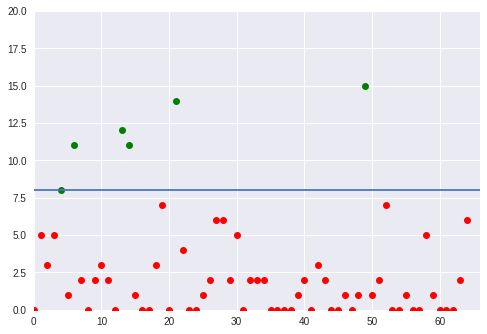

In [24]:
import numpy as np

b = 0
for i in plot_possible_scorers:
    if i in plot_scorers:
        print i
        plt.plot([b],[plot_possible_scorers[i]],'ro', color="g")
    else:
        plt.plot([b],[plot_possible_scorers[i]],'ro', color="r")
    b+=1

plt.axis([0, b+1, 0, 20])
plt.plot([0,b+1], [8, 8])

plt.show()